In [401]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np

close = pd.read_csv("close_data.csv")

close.index = pd.to_datetime(close['Date'], format='%Y-%m-%d')
close = close.drop('Date', axis=1)
close

,AAPL,AMZN,BRK-B,GOOGL,JNJ,META,MSFT,NVDA,TSLA,V
Date,,,,,,,,,,
2024-02-21,181.463181,168.589996,409.250000,142.035110,153.747635,466.743652,399.132782,67.452881,194.770004,274.710510
2024-02-22,183.503525,174.580002,415.160004,143.569534,155.462631,484.793915,408.531006,78.515747,197.410004,281.648743
2024-02-23,181.662216,174.990005,417.220001,143.440033,156.809418,482.699707,407.230957,78.794655,191.970001,281.499847
2024-02-26,180.308624,174.729996,409.140015,137.073105,155.792053,480.415955,404.452179,79.069588,199.399994,282.045776
2024-02-27,181.771698,173.539993,408.910004,138.378372,155.976166,485.711365,404.392609,78.678688,199.729996,281.073029
...,...,...,...,...,...,...,...,...,...,...
2025-02-14,244.600006,228.679993,479.589996,185.229996,154.910004,736.669983,407.612671,138.850006,355.839996,353.809998
2025-02-18,244.470001,226.649994,482.820007,183.770004,154.990005,716.369995,408.820282,139.399994,354.109985,356.730011
2025-02-19,244.869995,226.630005,483.769989,185.270004,157.889999,703.770020,413.940002,139.229996,360.559998,355.230011


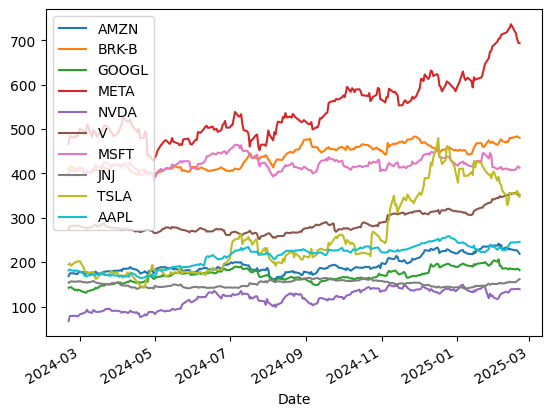

In [402]:
stock_to_use = 'AAPL'
stocks = ['AAPL', 'AMZN', 'BRK-B', 'GOOGL', 'META', 'NVDA', 'V', 'MSFT', 'JNJ', 'TSLA']

if stock_to_use in stocks:
    stocks.remove(stock_to_use)
else:
    print('ERROR')

stocks.append(stock_to_use)

stock_data = []

for i in stocks:
    stock_data.append(close[i])
    close[i].plot(label=i)

plt.legend()
#stock = close[stock_to_use]
#stock.plot()

In [403]:
def df_to_X_y(df, window_size=5):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size]
    y.append(label)
  return np.array(X), np.array(y)

WINDOW_SIZE = 5

X1 = np.array([])
y1 = np.array([])
for i in stock_data:
  X_temp, y_temp = df_to_X_y(i, WINDOW_SIZE)
  X1 = list(X1) + list(X_temp)
  y1 = np.concatenate((y1, y_temp))

#X1, y1 = df_to_X_y(stock, WINDOW_SIZE) ((247, 5, 1), (247,))
X1 = np.array(X1)
y1 = np.array(y1)
X1.shape, y1.shape


((2470, 5, 1), (2470,))

In [404]:
X_train1, y_train1 = X1[:1500], y1[:1500]
X_val1, y_val1 = X1[1500:-247], y1[1500:-247]
X_test1, y_test1 = X1[-247:], y1[-247:]
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((1500, 5, 1), (1500,), (723, 5, 1), (723,), (247, 5, 1), (247,))

In [405]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

model1 = Sequential()
model1.add(InputLayer((WINDOW_SIZE, 1)))
model1.add(LSTM(64))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

model1.summary()

Model: "sequential_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_30 (LSTM)                  │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,425 (68.07 KB)

 Trainable params: 17,425 (68.07 KB)

 Non-trainable params: 0 (0.00 B)

In [406]:
cp1 = ModelCheckpoint('model1/best_model.keras', save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.01), metrics=[RootMeanSquaredError()])

In [407]:
model1.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=15, callbacks=[cp1])

Epoch 1/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 103165.5938 - root_mean_squared_error: 321.1504 - val_loss: 62137.3242 - val_root_mean_squared_error: 249.2736
Epoch 2/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 69496.8750 - root_mean_squared_error: 262.8508 - val_loss: 21045.0664 - val_root_mean_squared_error: 145.0692
Epoch 3/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 29978.1641 - root_mean_squared_error: 172.9439 - val_loss: 6171.3672 - val_root_mean_squared_error: 78.5581
Epoch 4/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 10935.0410 - root_mean_squared_error: 104.2697 - val_loss: 254.9800 - val_root_mean_squared_error: 15.9681
Epoch 5/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2587.1594 - root_mean_squared_error: 50.7820 - val_loss: 64.6916 - val_root_mean_squared_error: 8.0431
Epoch 6/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1186.9326 - root_mean_squared_error: 34.2556 - val_loss: 79.2606 - val_root_mean_squared_error: 8.9028
Epoch 7/15

In [408]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_path = 'model1/best_model.keras'
cp1 = ModelCheckpoint(checkpoint_path, save_best_only=True)

In [409]:
train_predictions = model1.predict(X_test1).flatten()
train_results = pd.DataFrame(data={'Test Predictions':train_predictions, 'Actuals':y_test1})
train_results

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


,Test Predictions,Actuals
0,189.365555,180.567383
1,186.673447,179.900528
2,186.061417,178.815674
3,184.141006,174.277084
4,176.168533,169.320496
...,...,...
242,237.583252,244.600006
243,241.015732,244.470001
244,240.539627,244.869995
245,240.952301,245.830002


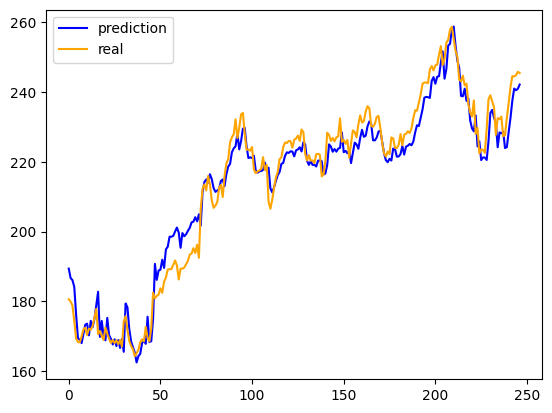

In [410]:
import matplotlib.pyplot as plt
plt.plot(train_results['Test Predictions'][:], color='blue', label='prediction')
plt.plot(train_results['Actuals'][:], color='orange', label='real')
plt.legend()
plt.show()


24.938082905883054


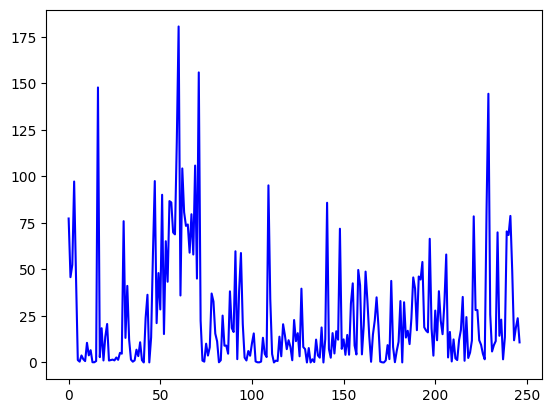

In [411]:
plt.plot(np.abs(train_results['Test Predictions'][:]-train_results['Actuals'][:])**2, color='blue', label='prediction')
print(np.mean(np.abs(train_results['Test Predictions'][:]-train_results['Actuals'][:])**2))

In [412]:
train_results.to_csv('test_results.csv', index=False)

# Load CSV into DataFrame
test_data = pd.read_csv('test_results.csv')

# Create a new column showing the difference
test_data['Difference'] = test_data['Test Predictions'] - test_data['Actuals']

# Calculate the difference from today to tomorrow for both columns
test_data['Predictions Difference'] = test_data['Test Predictions'].shift(-1) - test_data['Test Predictions']
test_data['Actuals Difference'] = test_data['Actuals'].shift(-1) - test_data['Actuals']

# Show the first few rows
test_data

,Test Predictions,Actuals,Difference,Predictions Difference,Actuals Difference
0,189.36555,180.567383,8.798167,-2.69210,-0.666855
1,186.67345,179.900528,6.772922,-0.61203,-1.084854
2,186.06142,178.815674,7.245746,-1.92042,-4.538589
3,184.14100,174.277084,9.863916,-7.97247,-4.956589
4,176.16853,169.320496,6.848034,-6.70311,-0.995316
...,...,...,...,...,...
242,237.58325,244.600006,-7.016756,3.43248,-0.130005
243,241.01573,244.470001,-3.454271,-0.47610,0.399994
244,240.53963,244.869995,-4.330365,0.41267,0.960007
245,240.95230,245.830002,-4.877702,1.22049,-0.369995


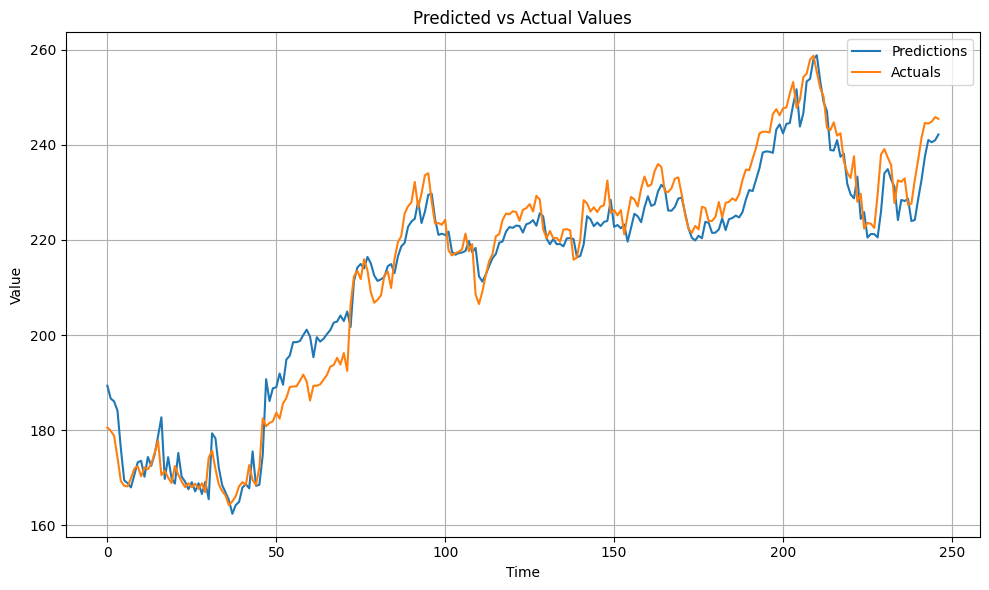

In [413]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(test_data['Test Predictions'], label='Predictions')
plt.plot(test_data['Actuals'], label='Actuals')
plt.title('Predicted vs Actual Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

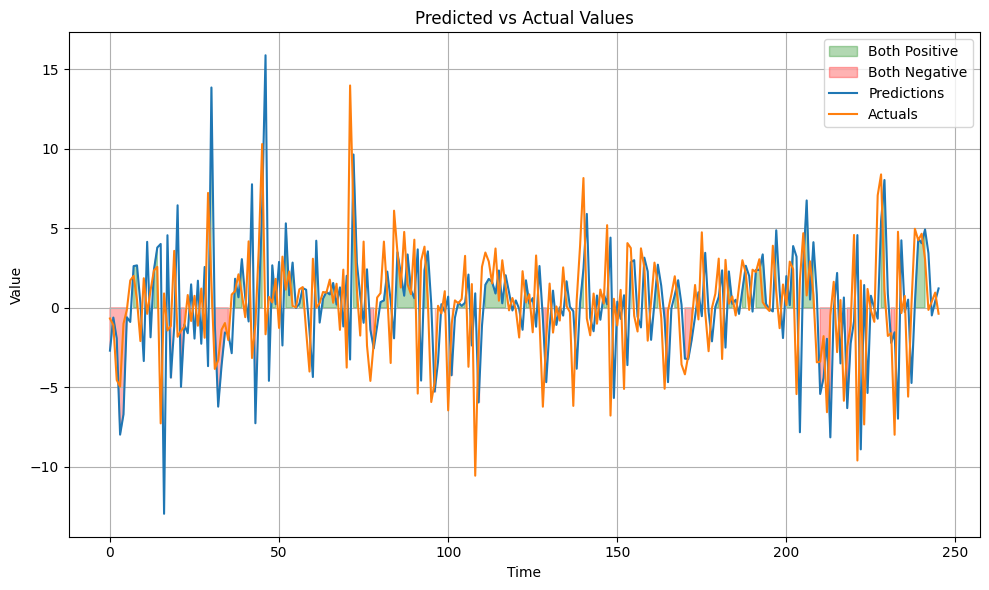

In [414]:
# Plotting
plt.figure(figsize=(10, 6))

# Highlighting where both predictions and actuals are positive
plt.fill_between(range(len(test_data['Predictions Difference'])), 0, test_data['Predictions Difference'], where=(test_data['Predictions Difference'] > 0) & (test_data['Actuals Difference'] > 0), color='green', alpha=0.3, label='Both Positive')

# Highlighting where both predictions and actuals are negative
plt.fill_between(range(len(test_data['Predictions Difference'])), 0, test_data['Predictions Difference'], where=(test_data['Predictions Difference'] < 0) & (test_data['Actuals Difference'] < 0), color='red', alpha=0.3, label='Both Negative')

plt.plot(test_data['Predictions Difference'], label='Predictions')
plt.plot(test_data['Actuals Difference'], label='Actuals')
plt.title('Predicted vs Actual Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [415]:
start_money = 100
current_money = start_money
current_stocks = 0

pred_dif = test_data['Predictions Difference']
actuals = test_data['Actuals']
own_stock = False


for day in range(246):
    if pred_dif[day] < 0 and own_stock:
        #Sell
        if current_money != 0:
            print('ERROR 1')
            
        current_money = current_stocks * actuals[day]
        current_stocks = 0
        own_stock = False
        
    elif pred_dif[day] > 0 and not own_stock:
        #Buy
        if current_stocks != 0:
            print('ERROR 2')
            
        current_stocks = current_money/actuals[day]
        current_money = 0
        own_stock = True

if own_stock:
    current_money = current_stocks * actuals[day]
    current_stocks = 0
    own_stock = False
    
print(current_money)



120.55722427612737
